In [2]:
from Dataset import VideoDataset
import os
import cv2
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from datetime import datetime, timedelta
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from Loss import FocalLoss
from torchvision import models
import albumentations as A
from Model_Softmax import CNNLSTMWithAttention,CNNLSTM
from sklearn.metrics import confusion_matrix
from Dataset import preprocessing,transform_aug
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
plt.rcParams["font.family"] = "Times New Roman"


c:\Users\zhChe\anaconda3\envs\CV\lib\site-packages\albumentations\__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.3' (you have '2.0.2'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
frame_width,frame_height = 250,150
x,y = 500,750
pt1_L = (x, y)
pt2_L = (x+frame_width, y+frame_height)
x,y = 1450,840
pt1_R = (x, y)
pt2_R = (x+frame_width, y+frame_height)
x,y = 1000,840
pt1_M = (x, y)
pt2_M = (x+frame_width, y+frame_height)
ROI_L, ROI_R, ROI_M = [pt1_L, pt2_L], [pt1_R, pt2_R], [pt1_M, pt2_M]

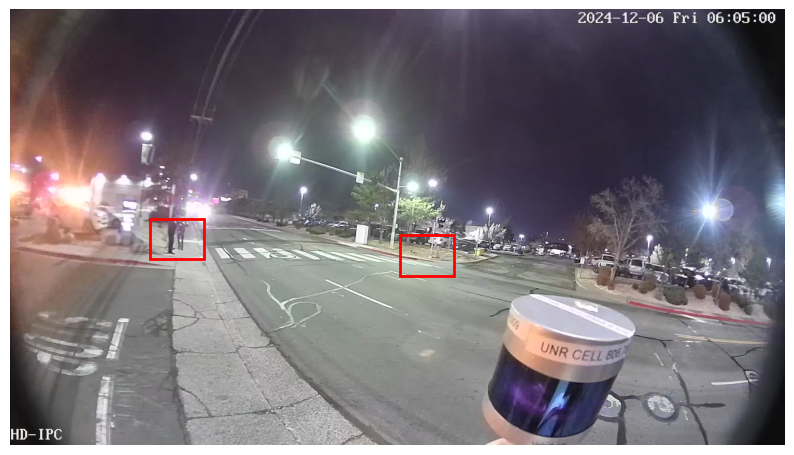

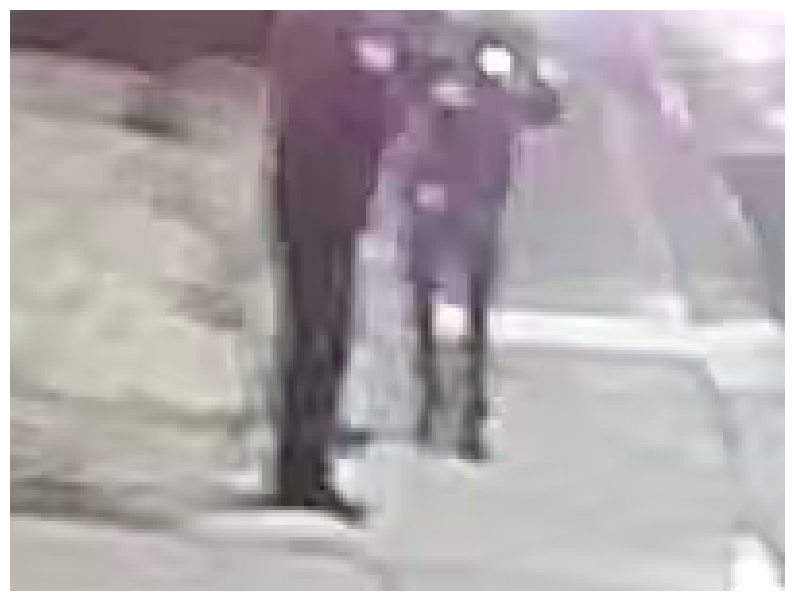

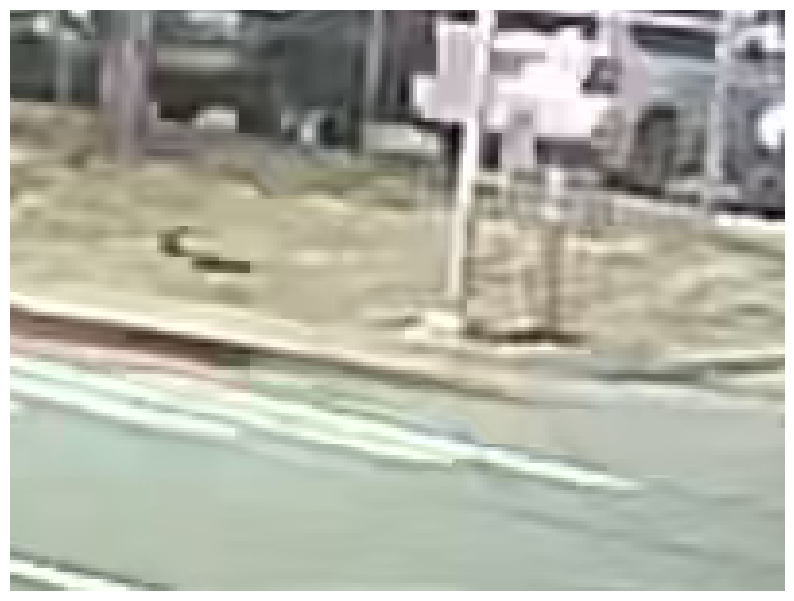

In [30]:
video_path = r'D:\LiDAR_Data\2ndPHB\Video\IntesectionVideo\00_00_192.168.1.108_1_20241206_060500.avi'
cap = cv2.VideoCapture(video_path)
frame = cap.read()[1]
cap.release()
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
# plot one frame
plt.figure(figsize=(10, 10))
plt.imshow(frame)
# draw the region of interests
plt.gca().add_patch(plt.Rectangle((pt1_L[0], pt1_L[1]), frame_width, frame_height, fill=None, edgecolor='r', linewidth=2))
plt.gca().add_patch(plt.Rectangle((pt1_R[0], pt1_R[1]), frame_width, frame_height, fill=None, edgecolor='r', linewidth=2))
# hide the x and y axis
plt.axis('off')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\single_frame.png')
plt.show()
cropped_frame = frame[pt1_L[1]:pt2_L[1], pt1_L[0]:pt2_L[0]]
plt.figure(figsize=(10, 10))
plt.imshow(cropped_frame)
plt.axis('off')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\cropped_frame.png')
plt.show()
cropped_frame = frame[pt1_R[1]:pt2_R[1], pt1_R[0]:pt2_R[0]]
plt.figure(figsize=(10, 10))
plt.imshow(cropped_frame)
plt.axis('off')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\cropped_frame.png')
plt.show()

In [82]:
input_video_path = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\train\2_2024-12-05-11-45-00_2658_L.mp4'
cap = cv2.VideoCapture(input_video_path)
if not cap.isOpened():
    print("Error: Cannot open video file.")
frames = []
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frames.append(frame)

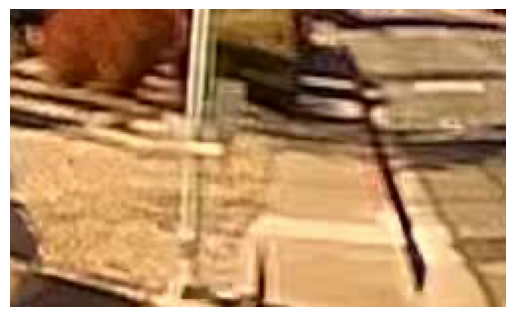

In [83]:
# plot one frame
plt.imshow(cv2.cvtColor(frames[0], cv2.COLOR_BGR2RGB))
# hide the x and y axis
plt.axis('off')
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\single_frame.png')
plt.show()

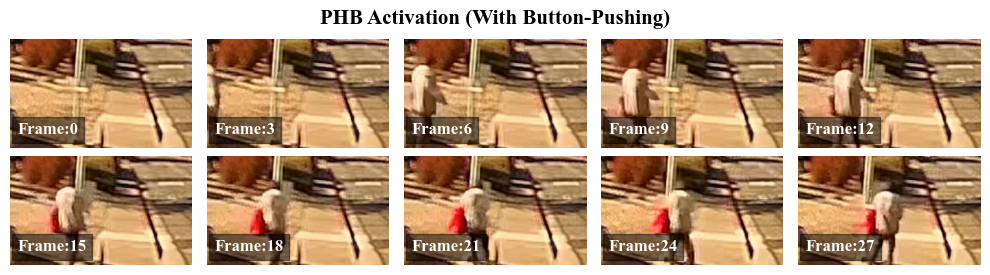

In [85]:
# plot all frames in 2 x 5 grid, with 3 frame step
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.cvtColor(frames[i * 3], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    # annotate frame number in bottom of each frame
    ax.annotate(f'Frame:{i*3}', (10, 130), color='white', weight='bold', fontsize=12,
                bbox=dict(facecolor='black', alpha=0.5))
# make row 1 and 2 closer
plt.subplots_adjust(hspace=-0.7)
plt.suptitle('PHB Activation (With Button-Pushing)', fontsize=15, weight='bold', y=0.75)
# title
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\Activation.png',dpi = 300)
plt.show()

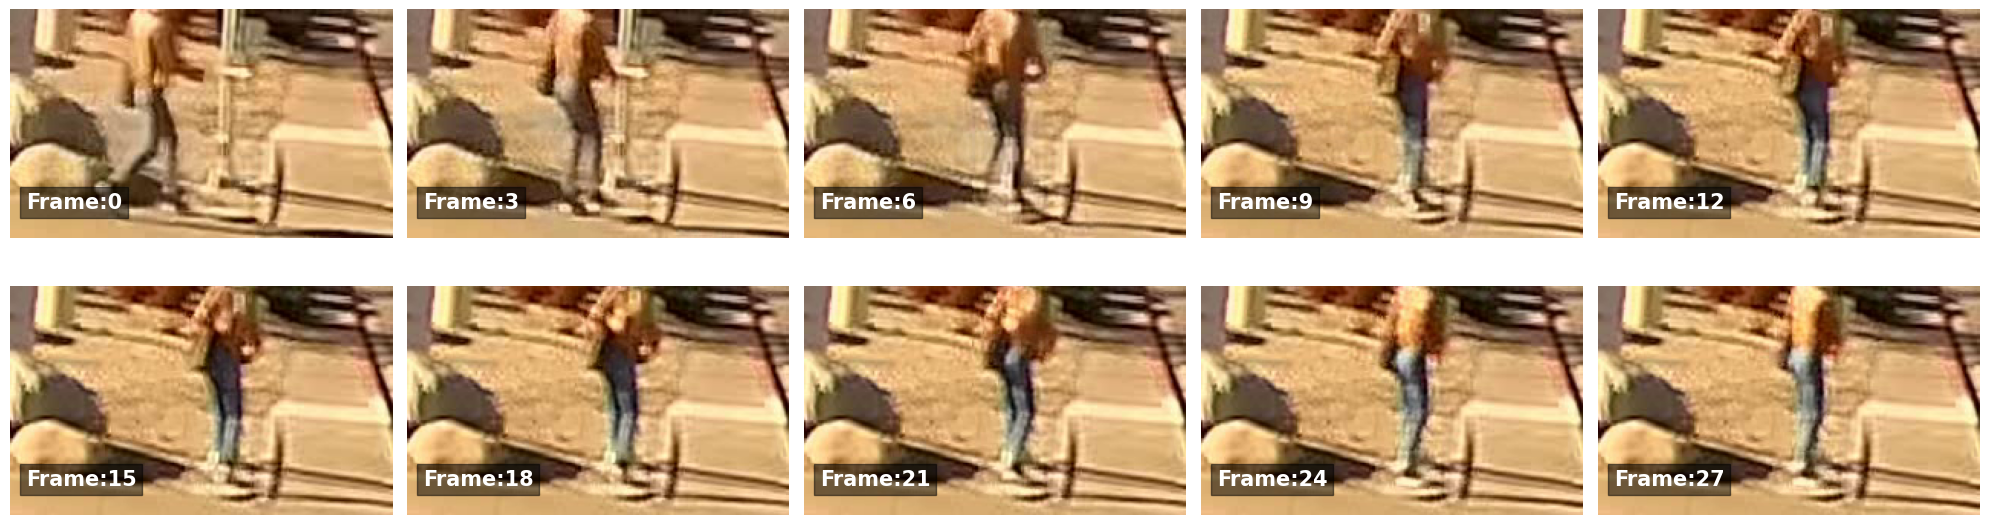

In [4]:
# plot all frames in 2 x 5 grid, with 3 frame step
fig, axs = plt.subplots(2, 5, figsize=(20, 10))
for i, ax in enumerate(axs.flat):
    ax.imshow(cv2.cvtColor(frames[i * 3], cv2.COLOR_BGR2RGB))
    ax.axis('off')
    # annotate frame number in bottom of each frame
    ax.annotate(f'Frame:{i*3}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
# make row 1 and 2 closer
plt.subplots_adjust(hspace=-0.7)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\frames_pushed.png',dpi = 300)
plt.tight_layout()

plt.show()

In [19]:
# Custom Transform for Normalization
def create_data_loaders(train_dir, val_dir, batch_size=4, preprocess=None, augmentation=None):
    train_dataset = VideoDataset(train_dir, preprocess=preprocess, augmentation=augmentation)
    val_dataset = VideoDataset(val_dir, preprocess=preprocess)
    # test_dataset = VideoDataset(test_dir, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size,shuffle=False)
    # test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader
from sklearn.metrics import confusion_matrix,precision_recall_fscore_support


In [20]:
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0128_FocalLoss_250x150_3class_256_Left_3CNN\model\best_model.pth"
num_classes = 3
model_L = CNNLSTMWithAttention(cnn_output_dim=256,
    lstm_hidden_dim=256,
    lstm_layers=1,
    num_classes = 3).to(device)
model_L.load_state_dict(torch.load(model_path,weights_only=True))
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0128_FocalLoss_250x150_3class_256_Right_3CNN\model\best_model.pth"
model_R = CNNLSTMWithAttention(cnn_output_dim=256,
    lstm_hidden_dim=256,
    lstm_layers=1,
    num_classes = 3).to(device)
model_R.load_state_dict(torch.load(model_path,weights_only=True))
models = [model_L, model_R]

In [21]:
# plot graph of confusion matrix 
import seaborn as sns

In [ ]:
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\train'
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
train_loader, val_loader = create_data_loaders(train_dir, test_dir, batch_size=2, preprocess=preprocessing, augmentation=transform_aug)
cnn_output_dim=128
lstm_hidden_dim=128
lstm_layers=1
num_classes = 3
model = CNNLSTMWithAttention(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
# model = CNNLSTM(cnn_output_dim=cnn_output_dim, lstm_hidden_dim=lstm_hidden_dim, lstm_layers=lstm_layers).to(device)
model_path = r"D:\LiDAR_Data\2ndPHB\Video\overall_0210_FocalLoss_250x150_3class_128_Left_3CNN\model\best_model.pth"
model.load_state_dict(torch.load(model_path,weights_only=True))
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    with tqdm(total=len(val_loader), desc="Validation") as pbar:
        for inputs, labels, _ in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float()
            outputs, attention_weights = model(inputs)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(torch.argmax(outputs,dim=1).cpu().numpy())
            pbar.update(1)
y_true = np.array(y_true)
y_pred = np.array(y_pred)
cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
precision, recall, F1, _ = precision_recall_fscore_support(y_true, y_pred, average=None, labels=list(range(num_classes)))

Validation: 100%|██████████| 1162/1162 [01:18<00:00, 14.72it/s]


In [4]:
np.e**(0.74 * np.log(19) + 2.89)

158.99692216549641

In [2]:
import numpy as np

In [88]:
precision, recall, F1

(array([0.98074609, 0.98113208, 0.93153153]),
 array([0.995116  , 0.71724138, 0.95740741]),
 array([0.98787879, 0.82868526, 0.94429224]))

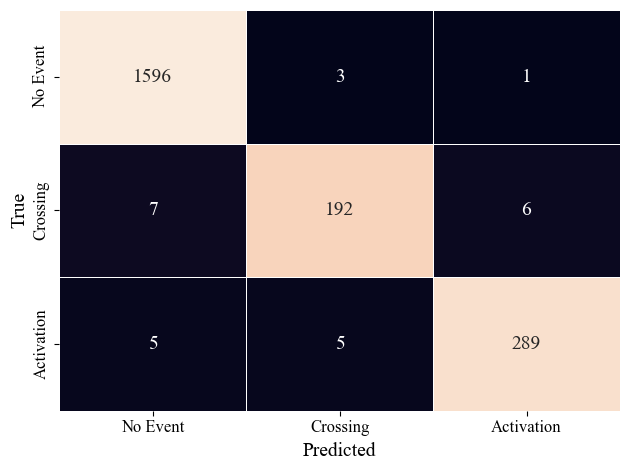

In [43]:
# Normalize the confusion matrix by row
cm_normalized = cm / cm.sum(axis=1, keepdims=True)

# Create the heatmap: colors based on the normalized values, but annotations are the original counts.
sns.heatmap(cm_normalized, annot=cm, fmt="d", cmap='rocket', cbar=False,
            annot_kws={"size": 14}, linewidths=0.5)

# Set the labels and ticks
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.xticks([0.5, 1.5, 2.5], ['No Event', 'Crossing', 'Activation'], fontsize=12)
plt.yticks([0.5, 1.5, 2.5], ['No Event', 'Crossing', 'Activation'], fontsize=12)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\confusion_matrix_R_128.png',dpi = 300)
plt.show()

In [240]:
def extract_optical_flow(frames):

    prev_frame = frames[0]
    prev_gray = cv2.cvtColor(prev_frame, cv2.COLOR_BGR2GRAY)
    optical_flow_frames = []
# Loop through video frames
    for i in range(1,len(frames)):
        next_frame = frames[i]
        next_gray = cv2.cvtColor(next_frame, cv2.COLOR_BGR2GRAY)
        flow = cv2.calcOpticalFlowFarneback(
            prev_gray, next_gray, None, 
            0.5, 3, 15, 3, 5, 1.2, 0
        )
    # Compute magnitude and angle
        magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
        # Normalize magnitude
        normalized_magnitude = cv2.normalize(magnitude, None, 0, 1, cv2.NORM_MINMAX)
        # Encode angle into sine and cosine
        # sin_angle = np.sin(angle)
        # cos_angle = np.cos(angle)
        # Stack the normalized magnitude, sin and cos angle
        optical_flow = np.stack([normalized_magnitude, angle], axis=-1)
        # Save or append the result
        optical_flow_frames.append(optical_flow)
        # Update the previous frame and previous gray
        prev_gray = next_gray

    optical_flow_frames = np.array(optical_flow_frames)

    return optical_flow_frames

In [243]:
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
val_dataset = VideoDataset(test_dir, preprocess=preprocessing)
val_dataset_raw = VideoDataset(test_dir)
class_type = []
locations = []
color_change_degree = []
crossing_inds = []
activation_inds = []
for i in tqdm(range(0, len(val_dataset))):
    frames,label,location = val_dataset[i]
    class_type.append(label) 
    locations.append(location)
    frames_raw,label,location = val_dataset_raw[i]
    color_change_degree.append(np.abs(np.diff(frames_raw[:,:,-50:],axis = 0)).sum())
    if label == 1:
        crossing_inds.append(i)
    elif label == 2:
        activation_inds.append(i)
    

100%|██████████| 2323/2323 [01:03<00:00, 36.58it/s]


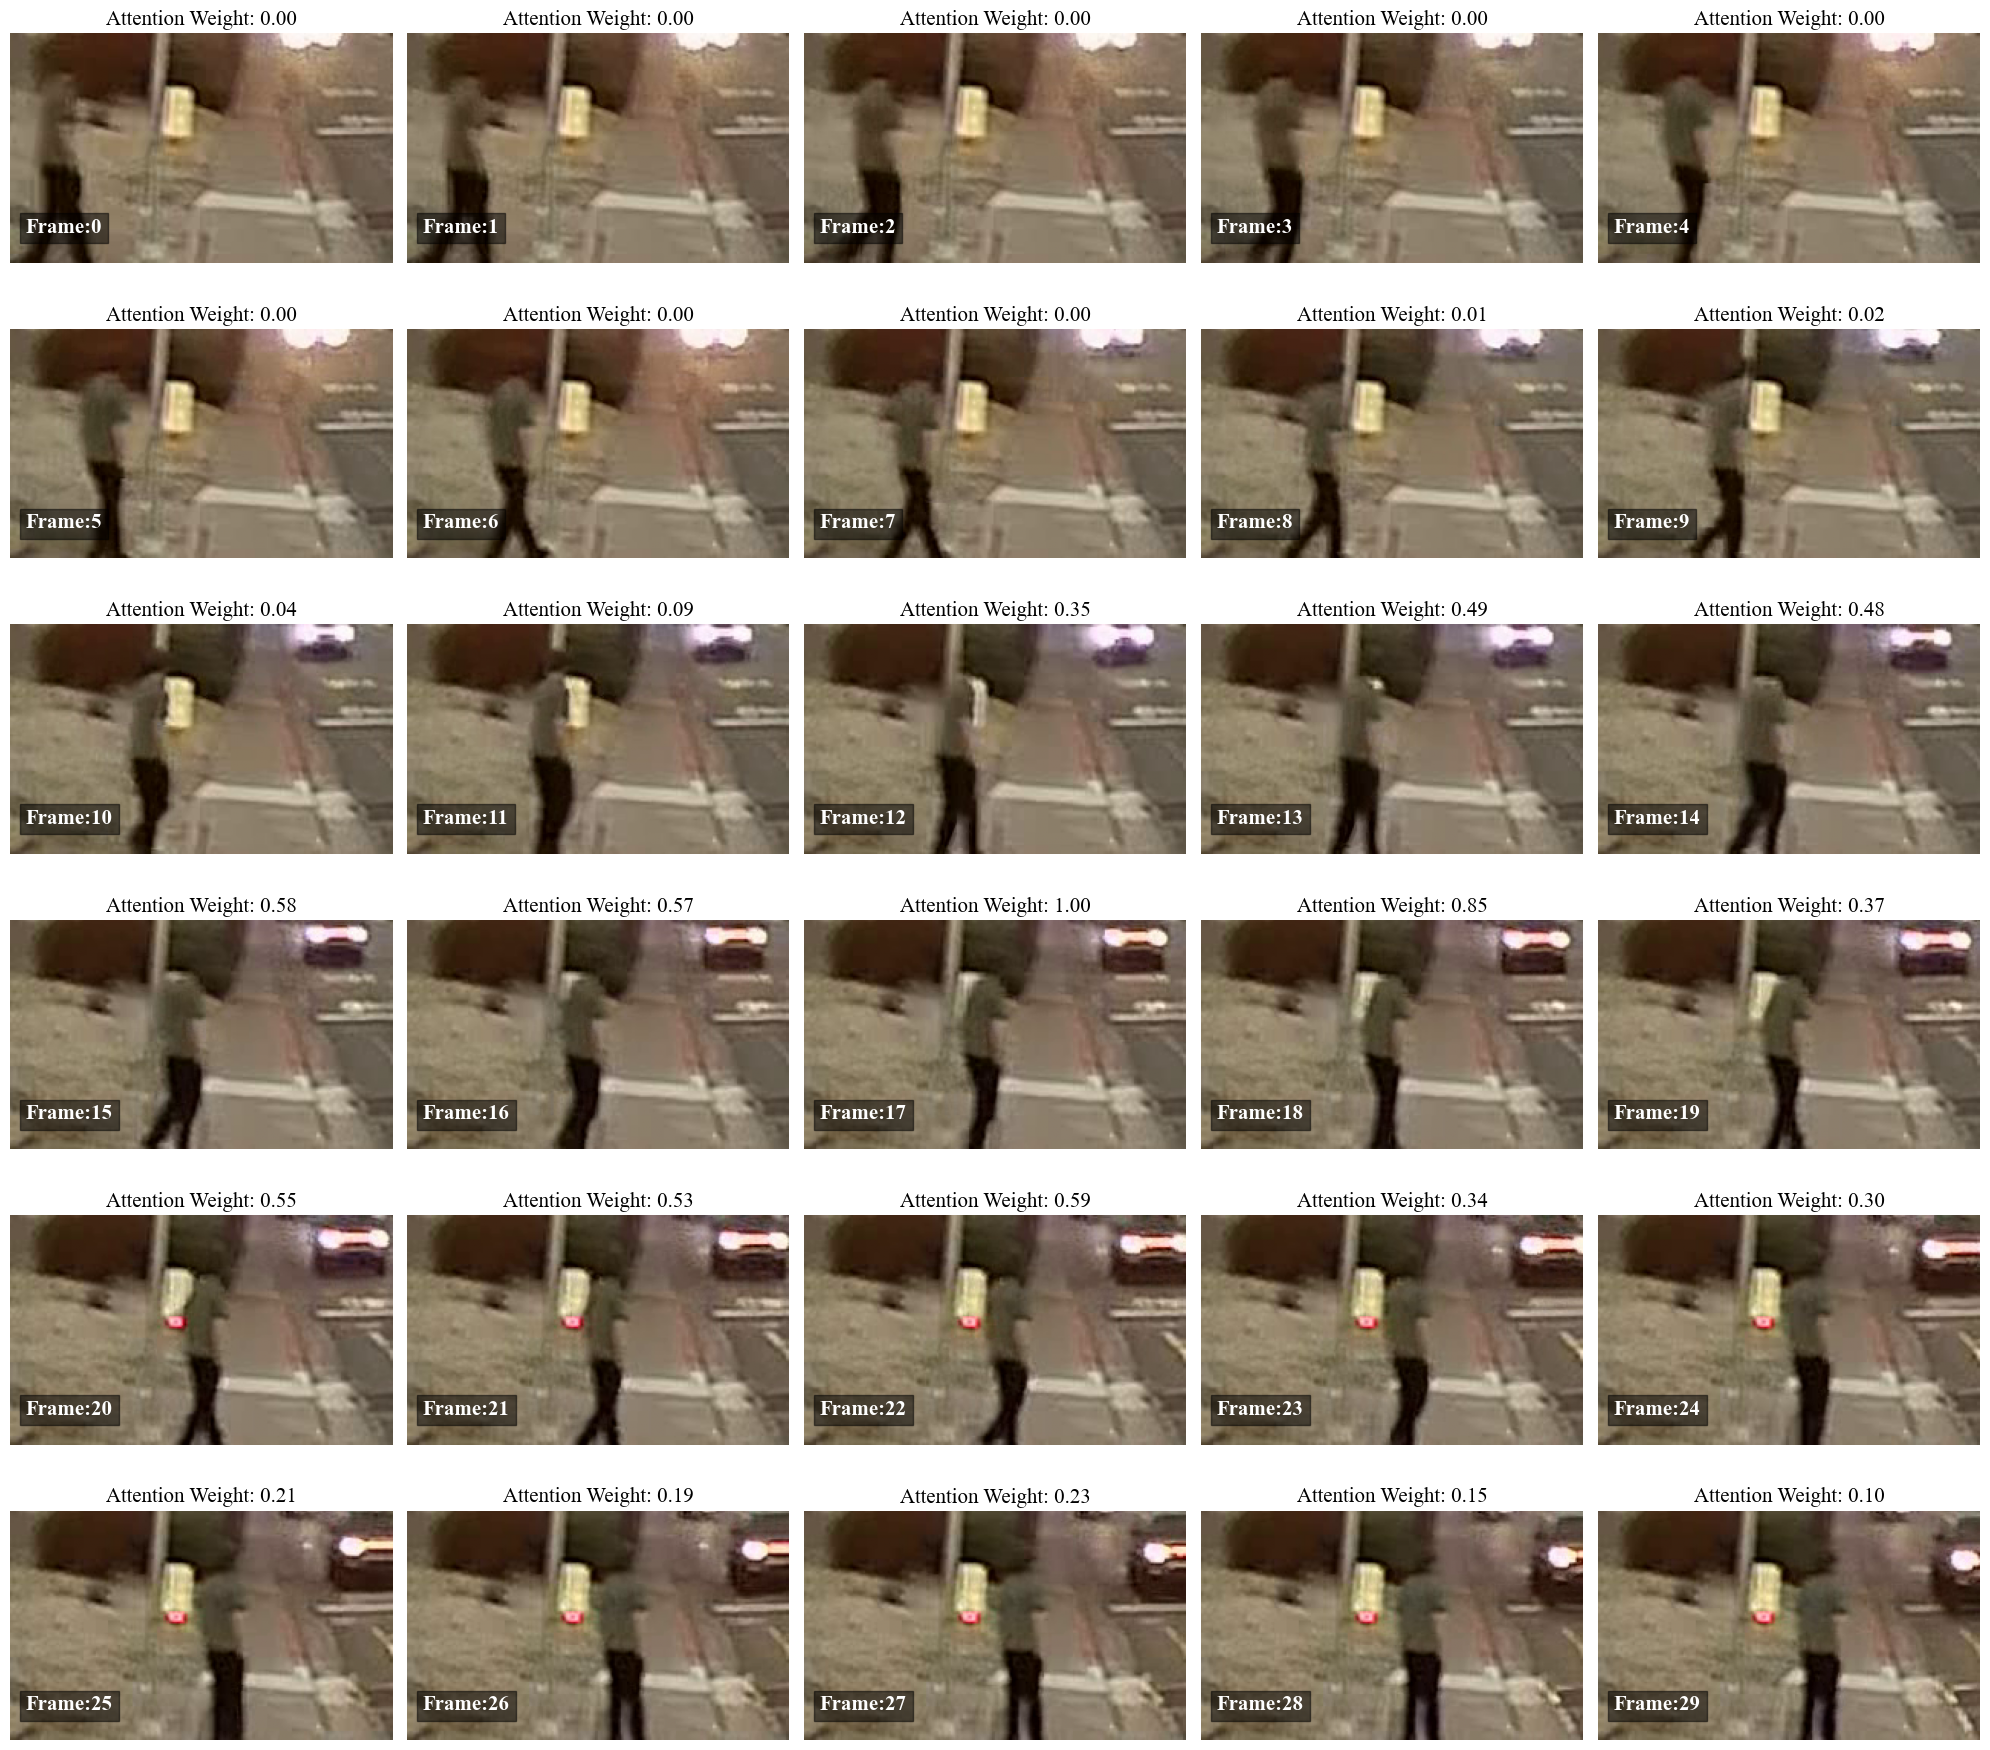

In [268]:
i = activation_inds[120]
frames,label,location = val_dataset[i]
frames = frames.unsqueeze(0).to(device)
output,attention_weights = model_L(frames)
attention_weights_numpy = attention_weights.squeeze(0).cpu().detach().numpy().flatten()
# normalize attention weights
attention_weights_numpy = attention_weights_numpy / attention_weights_numpy.max()
frames_raw,label,location = val_dataset_raw[i]
# plot frames with attention weights
fig, axs = plt.subplots(6, 5, figsize=(20, 20))
for i, ax in enumerate(axs.flat):
    temp = frames_raw[i]
    # normalize temp to [0, 1]
    temp = (temp - temp.min()) / (temp.max() - temp.min())
    ax.imshow(temp)
    ax.axis('off')
    ax.annotate(f'Frame:{i}', (10, 130), color='white', weight='bold', fontsize=15,
                bbox=dict(facecolor='black', alpha=0.5))
    ax.set_title(f'Attention Weight: {attention_weights_numpy[i]:.2f}', fontsize=15)
plt.tight_layout()
plt.subplots_adjust(hspace=-0.4)
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\attention_weights_animation.png',dpi = 300)
plt.show()

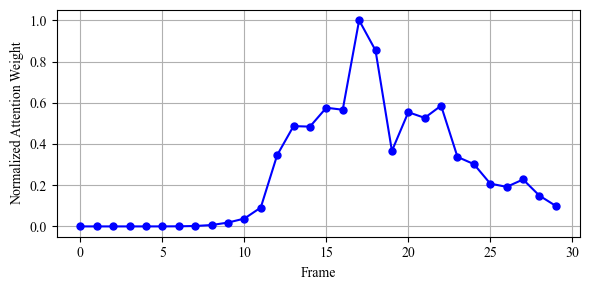

In [271]:
plt.figure(figsize=(6, 3))
plt.plot(attention_weights_numpy, color='b', marker='o', markersize=5)
plt.grid(True)
plt.xlabel('Frame')
plt.ylabel('Normalized Attention Weight')
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\attention_weights_curve.png')
plt.show()

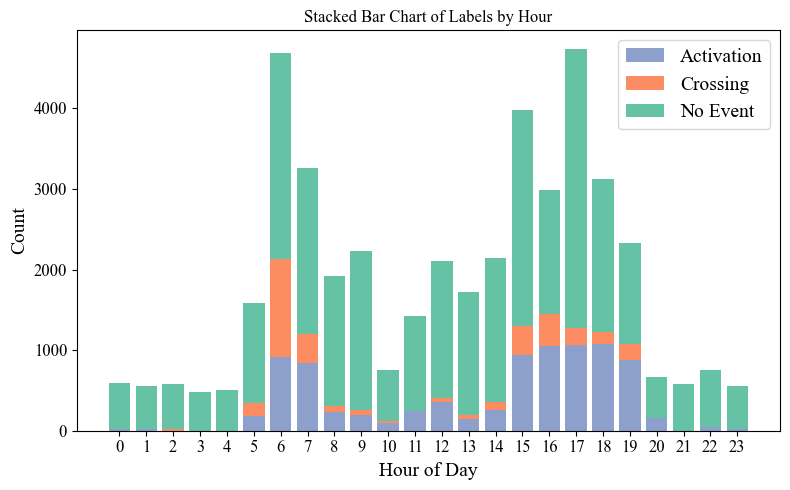

In [ ]:
data_dir = r'D:\LiDAR_Data\2ndPHB\Video\Clips'
data_list = os.listdir(data_dir)
labels = []
hours = []
locations = []
for data in data_list:
    label = data.split('_')[0]
    if label == '0':
        label = 'No Event'
    elif label == '1':
        label = 'Crossing'
    else:
        label = 'Activation'
    labels.append(label)
    date = data.split('_')[1]
    location = data.split('_')[3][0]
    locations.append(location)
    # convert hour to datetime
    # date = datetime.strptime(date, '%Y-%m-%d-%H-%M-%S')
    hours.append(int(date[11:13]))
df = pd.DataFrame({'label': labels, 'hour': hours, 'location': locations})
# Aggregate the data: count of each label per hour
counts = df.groupby(['hour', 'label']).size().unstack(fill_value=0)
counts = counts.sort_index()  # ensure hours are sorted

# Define an attractive color palette from Seaborn (Set2)
palette = sns.color_palette("Set2", 3)
colors = {'No Event': palette[0], 'Crossing': palette[1], 'Activation': palette[2]}

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Start with a baseline of zeros
bottom = np.zeros(len(counts))

# Plot each label's contribution in the stacked bar
for label in sorted(counts.columns):
    values = counts[label].values
    ax.bar(counts.index, values, bottom=bottom, color=colors[label],
           label=f'{label}', width=0.8)
    bottom += values  # update the bottom for stacking

# Add labels and title
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Stacked Bar Chart of Labels by Hour')
ax.legend(fontsize = 14)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\total_data_distribution.png')
plt.show()


In [407]:
# count number of labels in each location and dataset
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\test'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\valid'
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_L\train'
test_dataset = VideoDataset(test_dir)
val_dataset = VideoDataset(val_dir)
train_dataset = VideoDataset(train_dir)
test_labels = []
val_labels = []
train_labels = []
for i in range(len(test_dataset)):
    _, label, _ = test_dataset[i]
    test_labels.append(label)
for i in range(len(val_dataset)):
    _, label, _ = val_dataset[i]
    val_labels.append(label)
for i in range(len(train_dataset)):
    _, label, _ = train_dataset[i]
    train_labels.append(label)

test_labels = np.array(test_labels)
val_labels = np.array(val_labels)
train_labels = np.array(train_labels)
test_counts = np.bincount(test_labels)
val_counts = np.bincount(val_labels)
train_counts = np.bincount(train_labels)


In [416]:
# count number of labels in each location and dataset
test_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\test'
val_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\valid'
train_dir = r'D:\LiDAR_Data\2ndPHB\Video\Dataset_0123_R\train'
test_dataset = VideoDataset(test_dir)
val_dataset = VideoDataset(val_dir)
train_dataset = VideoDataset(train_dir)
test_labels = []
val_labels = []
train_labels = []
for i in range(len(test_dataset)):
    _, label, _ = test_dataset[i]
    test_labels.append(label)
for i in range(len(val_dataset)):
    _, label, _ = val_dataset[i]
    val_labels.append(label)
for i in range(len(train_dataset)):
    _, label, _ = train_dataset[i]
    train_labels.append(label)

test_labels = np.array(test_labels)
val_labels = np.array(val_labels)
train_labels = np.array(train_labels)
test_counts = np.bincount(test_labels)
val_counts = np.bincount(val_labels)
train_counts = np.bincount(train_labels)


In [158]:
training_curve_dir = r'D:\LiDAR_Data\2ndPHB\Video\overall_0202_FocalLoss_250x150_3class_512_Right_3CNN\curves\training_curves.pth'
training_curves = torch.load(training_curve_dir)

C:\Users\zhChe\AppData\Local\Temp\ipykernel_972\1839442228.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  training_curves = torch.load(training_curve_dir)


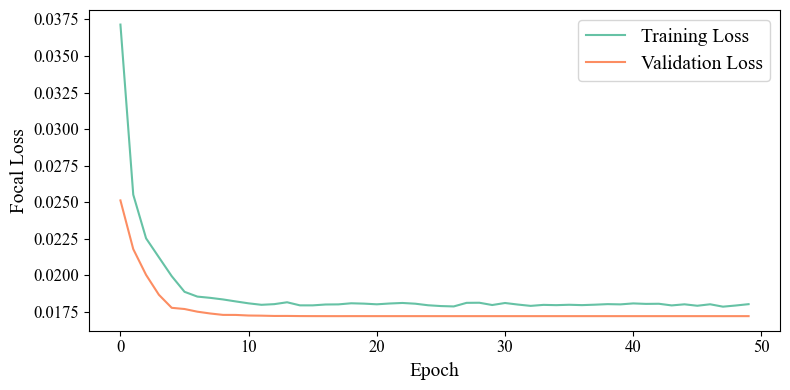

In [170]:
plt.figure(figsize=(8, 4))
plt.plot(np.array(training_curves['train']) / 1403, label='Training Loss', color=palette[0])
plt.plot(np.array(training_curves['val']) / 176, label='Validation Loss', color=palette[1])
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Focal Loss', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\training_curve.png')
plt.show()

In [51]:
OutFolder =r'D:\LiDAR_Data\2ndPHB\Video\total_predictions_0124'
OutList = os.listdir(OutFolder)
for file in OutList:
    df = pd.read_csv(os.path.join(OutFolder,file))
    if (df.Left_Activating > 0.9).sum()/len(df) > 0.8:
        print(file,'L')
    if (df.Right_Activating > 0.9).sum()/len(df) > 0.8:
        print(file,'R')

00_00_192.168.1.108_1_20241206_094500.csv R
00_00_192.168.1.108_1_20241208_094500.csv R


In [8]:
OutFolder =r'D:\LiDAR_Data\2ndPHB\Video\total_predictions_0124'
OutList = os.listdir(OutFolder)

In [9]:
def get_status(df):
    threshold = 0.95
    status = []
    for row in df.iterrows():
        row = row[1]
        if row.Left_Activating > threshold:
            status.append('Activating')
        elif row.Left_Crossing > threshold:
            status.append('Crossing')
        else:
            status.append('Normal')
    df['status_left'] = status
    status = []
    for row in df.iterrows():
        row = row[1]
        if row.Right_Activating > threshold:
            status.append('Activating')
        elif row.Right_Crossing > threshold:
            status.append('Crossing')
        else:
            status.append('Normal')
    df['status_right'] = status
    return df
def get_activation_summary(df, record_time, location = 'Left'):
    timet_delta = np.array([timedelta(seconds=int(i / 10)+3) for i in range(len(df))])
    df['timestamp'] = record_time + timet_delta
# identify the timestamp when the status changes from normal to activating or normal to crossing
    status_change = []
    event_type = []
    if location == 'Left':
        for i in range(1, len(df)):
            if df.status_left[i] != df.status_left[i - 1]:
                if df.status_left[i] != 'Normal':
                    status_change.append(df.timestamp[i])
                    event_type.append(df.status_left[i])
    elif location == 'Right':
        for i in range(1, len(df)):
            if df.status_right[i] != df.status_right[i - 1]:
                if df.status_right[i] != 'Normal':
                    status_change.append(df.timestamp[i])
                    event_type.append(df.status_right[i])
    status_change = np.array(status_change)
    event_type = np.array(event_type)
    summary = pd.DataFrame({'timestamp': status_change, 'event_type': event_type})
# if same event type happens within 5 seconds, keep the first one
    drop_inds = []
    for i in range(1, len(summary)):
        if summary.event_type[i] == summary.event_type[i - 1]:
            if summary.timestamp[i] - summary.timestamp[i - 1] < timedelta(seconds=10):
                drop_inds.append(i)
    summary = summary.drop(drop_inds)
    summary = summary.reset_index(drop=True)
    return summary

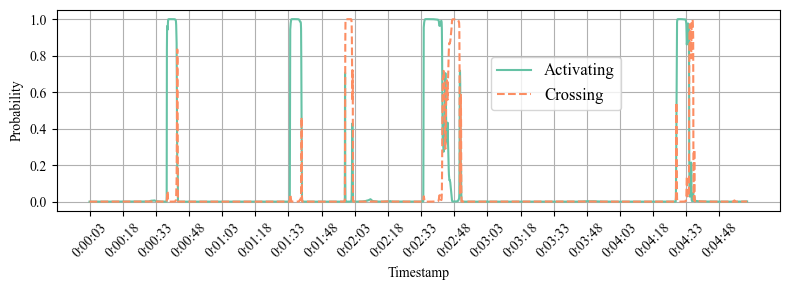

In [302]:
i = 305
palette = sns.color_palette("Set2", 3)
colors = {'Activation Crossing': palette[0], 'Dependent Crossing': palette[1], 'Independent Crossing': palette[2]}
df = pd.read_csv(os.path.join(OutFolder,OutList[i]))
date_str = OutList[i][22:-4]
record_time = datetime.strptime(date_str, '%Y%m%d_%H%M%S') 
plt.figure(figsize=(8, 3))
plt.grid(True)
plt.plot(df.Left_Activating, label='Activating', color= colors['Activation Crossing'])
plt.plot(df.Left_Crossing, label='Crossing', color = colors['Dependent Crossing'], linestyle='--')
# df.Left_Activating.plot()
# df.Left_Crossing.plot()
# tick, convert frame to time
plt.ylabel('Probability')
plt.xlabel('Timestamp')
plt.legend(fontsize=12,loc = [0.6,0.5])
timestamp = np.array([str(timedelta(seconds=int(i / 10)+3)) for i in range(len(df))])
plt.xticks(range(0, len(df), 150), timestamp[::150], rotation=45)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activation_curve.png')
plt.show()

# df = get_status(df)
# summary_left = get_activation_summary(df, record_time, location = 'Left')
# summary_right = get_activation_summary(df, record_time, location = 'Right')

In [193]:
OutDir = r'D:\LiDAR_Data\2ndPHB\Video\EvaluationRes_0202'
StatusSumFolder = os.path.join(OutDir, 'StatusSummary')
os.makedirs(StatusSumFolder, exist_ok=True)
ActivationSumLeftFolder = os.path.join(OutDir, 'ActivationSummaryLeft')
os.makedirs(ActivationSumLeftFolder, exist_ok=True)
ActivationSumRightFolder = os.path.join(OutDir, 'ActivationSummaryRight')
os.makedirs(ActivationSumRightFolder, exist_ok=True)
# convert OutList to date 
date_list = []
for file in OutList:
    date_str = file[22:-4]
    # '20241208_235500'
    date = datetime.strptime(date_str, '%Y%m%d_%H%M%S')
    date_list.append(date)
date_list = np.array(date_list)
OutList = np.array(OutList)
# sort OutList by date
OutList = OutList[np.argsort(date_list)]
for file in tqdm(OutList):
    df = pd.read_csv(os.path.join(OutFolder,file))
    df = get_status(df)
    record_time = datetime.strptime(file[22:-4], '%Y%m%d_%H%M%S')
    summary_left = get_activation_summary(df, record_time, location = 'Left')
    summary_right = get_activation_summary(df, record_time, location = 'Right')
    df.to_csv(os.path.join(StatusSumFolder,file),index = False)
    summary_left.to_csv(os.path.join(ActivationSumLeftFolder,file),index = False)
    summary_right.to_csv(os.path.join(ActivationSumRightFolder,file),index = False)

100%|██████████| 1236/1236 [05:06<00:00,  4.04it/s]


In [368]:
ActivationSumLeftFolder = os.path.join(OutDir, 'ActivationSummaryLeft')
summary_list = os.listdir(ActivationSumLeftFolder)
total_summary_left = []
for file in tqdm(summary_list):
    df = pd.read_csv(os.path.join(ActivationSumLeftFolder,file))
    total_summary_left.append(df)
total_summary_left = pd.concat(total_summary_left)
total_summary_left.timestamp = pd.to_datetime(total_summary_left.timestamp)
# sort by timestamp
total_summary_left = total_summary_left.sort_values(by='timestamp')
total_summary_left = total_summary_left.reset_index(drop=True)
total_summary_left.to_csv(os.path.join(OutDir,'total_summary_left.csv'),index = False)

ActivationSumRightFolder = os.path.join(OutDir, 'ActivationSummaryRight')
summary_list = os.listdir(ActivationSumRightFolder)
total_summary_right = []
for file in tqdm(summary_list):
    df = pd.read_csv(os.path.join(ActivationSumRightFolder,file))
    total_summary_right.append(df)
total_summary_right = pd.concat(total_summary_right)
total_summary_right.timestamp = pd.to_datetime(total_summary_right.timestamp)
total_summary_right = total_summary_right.reset_index(drop=True)
# sort by timestamp
total_summary_right = total_summary_right.sort_values(by='timestamp')
total_summary_right.to_csv(os.path.join(OutDir,'total_summary_right.csv'),index = False)

100%|██████████| 1236/1236 [00:04<00:00, 296.50it/s]


In [5]:
OutDir = r'D:\LiDAR_Data\2ndPHB\Video\EvaluationRes_0202'
total_summary_right = pd.read_csv(os.path.join(OutDir,'total_summary_right.csv'))
total_summary_left = pd.read_csv(os.path.join(OutDir,'total_summary_left.csv'))

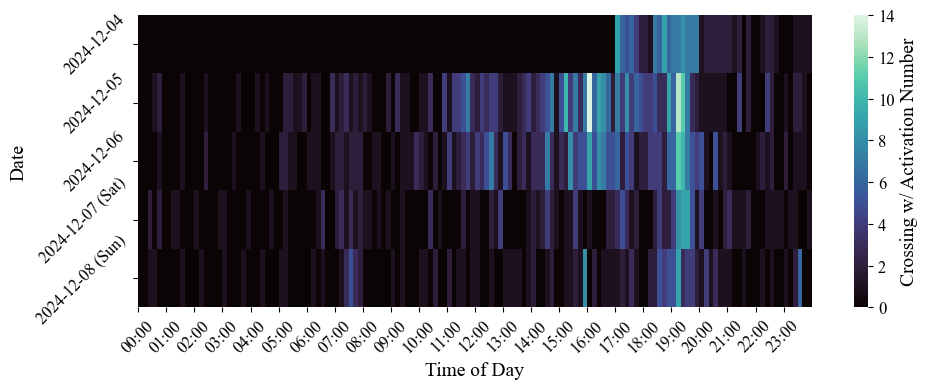

In [387]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Assuming total_summary_left is already defined ---

# Create a grid for total_summary_left
grid = np.zeros((24 * 6, 5))
for date_ind in range(5):
    for time_ind in range(24 * 6):
        start_time = datetime(2024, 12, 4 + date_ind, time_ind // 6, (time_ind % 6) * 10)
        end_time = start_time + timedelta(minutes=10)
        mask = (
            (total_summary_left.timestamp >= start_time) &
            (total_summary_left.timestamp < end_time) &
            (total_summary_left.event_type == 'Activating')
        )
        activation_number = len(total_summary_left[mask])
        grid[time_ind, date_ind] = activation_number

# Erase data between 2024-12-06 05:00 to 06:00 (assuming index positions 30 to 37 for day index 2)
grid[30:32, 2] = 2
grid[32:34, 2] = 1
grid[34:36, 2] = 0
grid[36:38, 2] = 1
# Plot the grid as a heatmap
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    grid.T,
    cmap='mako',  # Using the same attractive colormap
    cbar_kws={'label': 'Crossing w/ Activation Number'}
)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Date', fontsize=14)
plt.yticks(
    np.arange(0, 5) + 0.5,
    ['2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07 (Sat)', '2024-12-08 (Sun)'],
    fontsize=12,
    rotation=45
)
plt.xticks(fontsize=12)

# Set xticks to show time of day in HH:MM format
time_str = []
for i in range(0, 24 * 6, 6):
    time_str.append(datetime(2024, 12, 4, i // 6, (i % 6) * 10).strftime('%H:%M'))
plt.xticks(range(0, 24 * 6, 6), time_str, rotation=45)

# Adjust the colorbar font sizes:
cbar = ax.collections[0].colorbar
cbar.set_label('Crossing w/ Activation Number', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activation_heatmap_left.png')
plt.show()


In [388]:
activation_grid_left = grid.copy()

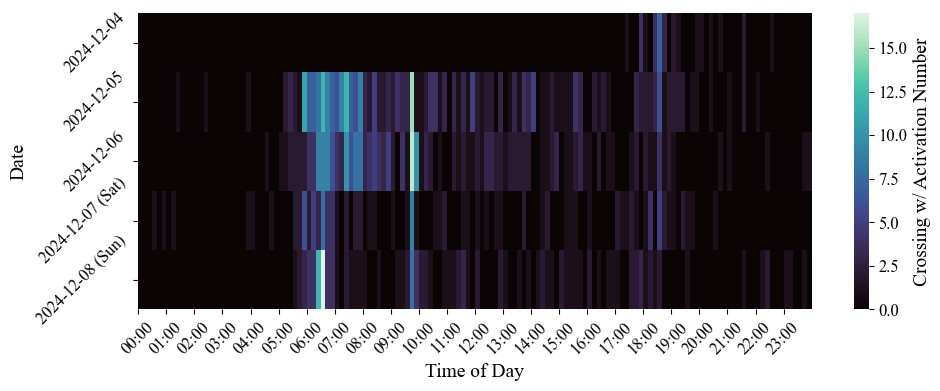

In [389]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# --- Assuming total_summary_left is already defined ---

# Create a grid for total_summary_left
grid = np.zeros((24 * 6, 5))
for date_ind in range(5):
    for time_ind in range(24 * 6):
        start_time = datetime(2024, 12, 4 + date_ind, time_ind // 6, (time_ind % 6) * 10)
        end_time = start_time + timedelta(minutes=10)
        mask = (
            (total_summary_right.timestamp >= start_time) &
            (total_summary_right.timestamp < end_time) &
            (total_summary_right.event_type == 'Activating')
        )
        activation_number = len(total_summary_right[mask])
        grid[time_ind, date_ind] = activation_number

# Erase data between 2024-12-06 05:00 to 06:00 (assuming index positions 30 to 37 for day index 2)
grid[30:32, 2] = 1
grid[32:36, 2] = 2
grid[36:38, 2] = 4

# Plot the grid as a heatmap
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    grid.T,
    cmap='mako',  # Using the same attractive colormap
    cbar_kws={'label': 'Crossing w/ Activation Number'}
)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Date', fontsize=14)
plt.yticks(
    np.arange(0, 5) + 0.5,
    ['2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07 (Sat)', '2024-12-08 (Sun)'],
    fontsize=12,
    rotation=45
)

plt.xticks(fontsize=12)
# Set xticks to show time of day in HH:MM format
time_str = []
for i in range(0, 24 * 6, 6):
    time_str.append(datetime(2024, 12, 4, i // 6, (i % 6) * 10).strftime('%H:%M'))
plt.xticks(range(0, 24 * 6, 6), time_str, rotation=45)

# Adjust the colorbar font sizes:
cbar = ax.collections[0].colorbar
cbar.set_label('Crossing w/ Activation Number', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()

plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activation_heatmap_right.png')
plt.show()


In [390]:
activation_grid_right = grid.copy()

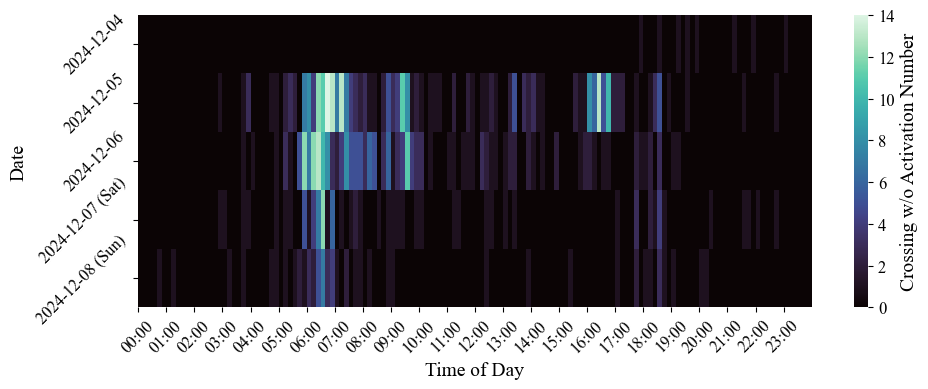

In [391]:
total_summary_right
# from 2024-12-04 to 2024-12-08, create grid of 10 minutes for x-axis, y-axis is the date to count the activation number
grid = np.zeros((24*6,5))
for date_ind in range(5):
    for time_ind in range(24*6):
        start_time = datetime(2024, 12, 4+date_ind, time_ind//6, (time_ind % 6)*10)
        end_time = start_time + timedelta(minutes=10)
        mask = (total_summary_right.timestamp >= start_time) & (total_summary_right.timestamp < end_time) 
        temp = total_summary_right[mask].copy().reset_index(drop = True)
        activation_number = 0
        if len(temp) == 0:
            activation_number = 0
        elif len(temp) == 1:
            if temp.iloc[0].event_type == 'Crossing':
                activation_number = 1
        else:
            for i in range(1,len(temp)):
                if temp.iloc[i].event_type == 'Crossing':
                    if temp.iloc[i-1].event_type == 'Activating':
                        if temp.iloc[i].timestamp - temp.iloc[i-1].timestamp > timedelta(seconds = 10):
                            activation_number += 1
                    else:
                        activation_number += 1
            # activation_number += len(temp[temp.event_type == 'Activating'])
        grid[time_ind, date_ind] = activation_number
# Plot the grid as a heatmap
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    grid.T,
    cmap='mako',  # Using the same attractive colormap
    cbar_kws={'label': 'Crossing w/o Activation Number'}
)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Date', fontsize=14)
plt.yticks(
    np.arange(0, 5) + 0.5,
    ['2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07 (Sat)', '2024-12-08 (Sun)'],
    fontsize=12,
    rotation=45
)

plt.xticks(fontsize=12)

# Set xticks to show time of day in HH:MM format
time_str = []
for i in range(0, 24 * 6, 6):
    time_str.append(datetime(2024, 12, 4, i // 6, (i % 6) * 10).strftime('%H:%M'))
plt.xticks(range(0, 24 * 6, 6), time_str, rotation=45)

# Adjust the colorbar font sizes:
cbar = ax.collections[0].colorbar
cbar.set_label('Crossing w/o Activation Number', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()

plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\crossing_heatmap_right.png')
plt.show()

In [392]:
crossing_grid_right = grid.copy()

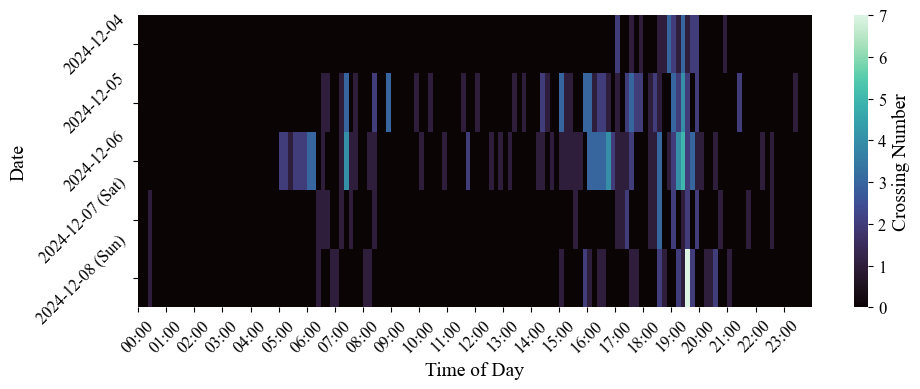

In [393]:
total_summary_left
# from 2024-12-04 to 2024-12-08, create grid of 10 minutes for x-axis, y-axis is the date to count the activation number
grid = np.zeros((24*6,5))
for date_ind in range(5):
    for time_ind in range(24*6):
        start_time = datetime(2024, 12, 4+date_ind, time_ind//6, (time_ind % 6)*10)
        end_time = start_time + timedelta(minutes=10)
        mask = (total_summary_left.timestamp >= start_time) & (total_summary_left.timestamp < end_time) 
        temp = total_summary_left[mask].copy().reset_index(drop = True)
        activation_number = 0
        if len(temp) == 0:
            activation_number = 0
        elif len(temp) == 1:
            if temp.iloc[0].event_type == 'Crossing':
                activation_number = 1
        else:
            for i in range(1,len(temp)):
                if temp.iloc[i].event_type == 'Crossing':
                    if temp.iloc[i-1].event_type == 'Activating':
                        if temp.iloc[i].timestamp - temp.iloc[i-1].timestamp > timedelta(seconds = 10):
                            activation_number += 1
                    else:
                        activation_number += 1
            # activation_number += len(temp[temp.event_type == 'Activating'])
        grid[time_ind, date_ind] = activation_number
grid[30:32, 2] = 2
grid[32:33, 2] = 1
grid[33:36, 2] = 2
grid[36:38, 2] = 3
# Plot the grid as a heatmap
plt.figure(figsize=(10, 4))
ax = sns.heatmap(
    grid.T,
    cmap='mako',  # Using the same attractive colormap
    cbar_kws={'label': 'Crossing Number'}
)
plt.xlabel('Time of Day', fontsize=14)
plt.ylabel('Date', fontsize=14)
plt.yticks(
    np.arange(0, 5) + 0.5,
    ['2024-12-04', '2024-12-05', '2024-12-06', '2024-12-07 (Sat)', '2024-12-08 (Sun)'],
    fontsize=12,
    rotation=45
)

plt.xticks(fontsize=12)

# Set xticks to show time of day in HH:MM format
time_str = []
for i in range(0, 24 * 6, 6):
    time_str.append(datetime(2024, 12, 4, i // 6, (i % 6) * 10).strftime('%H:%M'))
plt.xticks(range(0, 24 * 6, 6), time_str, rotation=45)

# Adjust the colorbar font sizes:
cbar = ax.collections[0].colorbar
cbar.set_label('Crossing Number', fontsize=14)
cbar.ax.tick_params(labelsize=12)
plt.tight_layout()


plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\crossing_heatmap_left.png')
plt.show()

In [394]:
crossing_grid_left = grid.copy()

In [548]:
activation_average_day_mean_left = activation_grid_left[:,1:].sum(axis = 1)/4
crossing_average_day_mean_left = crossing_grid_left[:,1:].sum(axis = 1)/4
activation_average_day_mean_right = activation_grid_right[:,1:].sum(axis = 1)/4
crossing_average_day_mean_right = crossing_grid_right[:,1:].sum(axis = 1)/4
# convert to 24 hours by summing up the activation number for each 10 minutes
activation_average_day_mean_left_hourly = activation_average_day_mean_left.reshape(24,6).sum(axis = 1) 
crossing_average_day_mean_left_hourly = crossing_average_day_mean_left.reshape(24,6).sum(axis = 1)
activation_average_day_mean_right_hourly = activation_average_day_mean_right.reshape(24,6).sum(axis = 1)
crossing_average_day_mean_right_hourly = crossing_average_day_mean_right.reshape(24,6).sum(axis = 1)
counts = np.c_[activation_average_day_mean_left_hourly,crossing_average_day_mean_left_hourly,activation_average_day_mean_right_hourly,crossing_average_day_mean_right_hourly]
df = pd.DataFrame(counts,columns = ['Left_Activation','Left_Crossing','Right_Activation','Right_Crossing'])
df.index = range(24)
df['hour'] = df.index

In [559]:
(df.Left_Activation + df.Right_Activation).sum() / (df.Left_Activation + df.Right_Activation + df.Left_Crossing + df.Right_Crossing).sum()

0.6720321931589537

In [568]:
(df.Left_Activation + df.Right_Activation).sum()/(df.Left_Activation + df.Right_Activation + df.Left_Crossing + df.Right_Crossing).sum()

0.6720321931589537

In [563]:
counts = df[['Left_Activation','Left_Crossing']]

In [567]:
counts.iloc[19].Left_Crossing/counts.iloc[19].sum()

0.24873096446700507

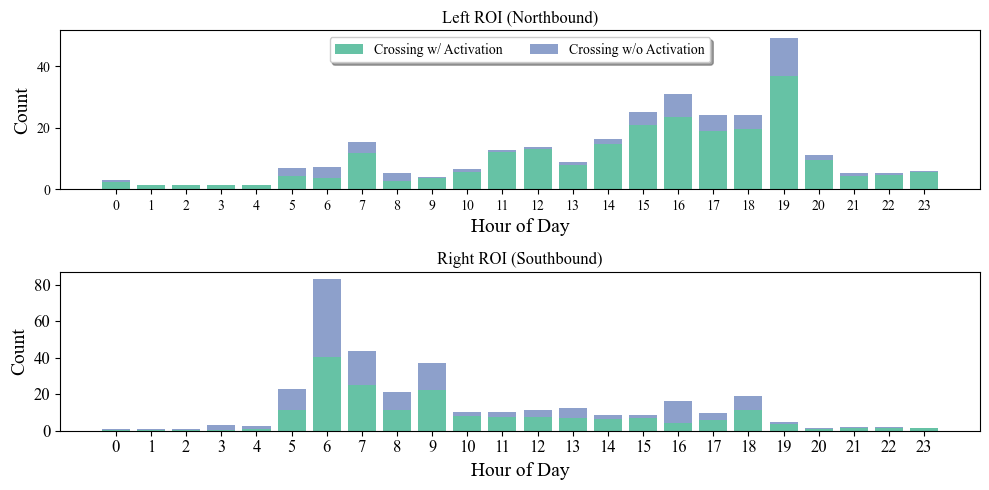

In [560]:

# Define an attractive color palette from Seaborn (Set2)
palette = sns.color_palette("Set2", 3)
colors = {'Crossing w/ Activation': palette[0], 'Crossing w/o Activation': palette[2]}

# Create the stacked bar chart
fig, axs = plt.subplots( 2, 1, figsize=(10, 5))
counts = df[['Left_Activation','Left_Crossing']]
# Start with a baseline of zeros
bottom = np.zeros(24)
# Plot each label's contribution in the stacked bar
for label in sorted(counts.columns):
    values = counts[label].values
    if label == 'Left_Activation':
        label = 'Crossing w/ Activation'
    else:
        label = 'Crossing w/o Activation'
    axs[0].bar(counts.index, values, bottom=bottom, color=colors[label],
           label=f'{label}', width=0.8)
    bottom += values  # update the bottom for stacking
# Add labels and title
axs[0].set_xlabel('Hour of Day', fontsize=14)
axs[0].set_ylabel('Count', fontsize=14)
axs[0].set_title('Left ROI (Northbound)')
# ax.set_title('Stacked Bar Chart of Labels by Hour')
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, 1),
          ncol=3, fancybox=True, shadow=True)
axs[0].set_xticks(range(24))
colors = {'Crossing w/ Activation': palette[0], 'Crossing w/o Activation': palette[2]}

axs[0].set_xticklabels(range(24))
counts = df[['Right_Activation','Right_Crossing']]
# Start with a baseline of zeros
bottom = np.zeros(24)
# Plot each label's contribution in the stacked bar
for label in sorted(counts.columns):
    values = counts[label].values
    if label == 'Right_Activation':
        label = 'Crossing w/ Activation'
    else:
        label = 'Crossing w/o Activation'
    axs[1].bar(counts.index, values, bottom=bottom, color=colors[label],
           label=f'{label}', width=0.8)
    bottom += values  # update the bottom for stacking
# Add labels and title
axs[1].set_xlabel('Hour of Day', fontsize=14)
axs[1].set_ylabel('Count', fontsize=14)
axs[1].set_title('Right ROI (Southbound)')
# ax.set_title('Stacked Bar Chart of Labels by Hour')
# axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
#           ncol=3, fancybox=True, shadow=True)
axs[1].set_xticks(range(24))
axs[1].set_xticklabels(range(24))

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
# plt.ylim(0, 1)
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\CrossingTypeCount.png',dpi = 300)
plt.show()


In [ ]:
df = total_summary_left
# Aggregate the data: count of each label per hour
counts = df.groupby(['hour', 'PHB_status']).size().unstack(fill_value=0)
counts = counts.sort_index()  # ensure hours are sorted

# Define an attractive color palette from Seaborn (Set2)
palette = sns.color_palette("Set2", 3)
colors = {'Activation Crossing': palette[0], 'Dependent Crossing': palette[1], 'Independent Crossing': palette[2]}

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Start with a baseline of zeros
bottom = np.zeros(len(counts))

# Plot each label's contribution in the stacked bar
for label in sorted(counts.columns):
    values = counts[label].values
    ax.bar(counts.index, values, bottom=bottom, color=colors[label],
           label=f'{label}', width=0.8)
    bottom += values  # update the bottom for stacking
# Add labels and title
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
# ax.set_title('Stacked Bar Chart of Labels by Hour')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          ncol=3, fancybox=True, shadow=True)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
indepenant_crossing_portion = counts.loc[:,'Independent Crossing']/counts.sum(axis = 1)
# show the portion of indepenant crossing. use right y-axis as the portion
ax2 = ax.twinx()
ax2.plot(indepenant_crossing_portion, color = 'lightcoral', label = 'Independent Crossing Portion', marker = 'o', alpha = 0.99)
ax2.set_ylabel('Independent Crossing Portion', fontsize=14)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\utilization.png')
plt.show()


In [7]:
# PHB serving time (sec)
flashing_yellow = 5
steady_yellow = 2
steady_red = 15
flashing_red = 25
# identify the utilization of PHB based on the activation and crossing events
# we want to identify the events when crossing without activations (no activation before steady red + flashing red)
total_serving_time = flashing_yellow + steady_yellow + steady_red + flashing_red
# find critical activation time (no another activation before activation - total_serving_time)
total_summary_left['location'] = 'Left'
total_summary_right['location'] = 'Right'
total_record_both_way = pd.concat([total_summary_left, total_summary_right])
# sort by timestamp
total_record_both_way = total_record_both_way.sort_values(by='timestamp')
total_record_both_way = total_record_both_way.reset_index(drop=True)

In [10]:
total_record_both_way.timestamp = pd.to_datetime(total_record_both_way.timestamp)

In [11]:
drop_inds = []
for i in range(1, len(total_record_both_way)):
    if total_record_both_way.location[i] == total_record_both_way.location[i-1]:
        if total_record_both_way.event_type[i] == 'Crossing':
            if total_record_both_way.event_type[i-1] == 'Activating':
                if total_record_both_way.timestamp[i] - total_record_both_way.timestamp[i-1] < timedelta(seconds = 13):
                    drop_inds.append(i)
# Drop the crossing events that are immediately after activation
total_record_both_way = total_record_both_way.drop(drop_inds)
total_record_both_way = total_record_both_way.reset_index(drop=True)
# Activating count as one crossing
# We want to identify: 1) crossing without PHB serving; 2) crossing with PHB serving but without activation; 3) crossing with PHB serving and activation
indepenant_crossing = [] 
# crossing without PHB serving
for i in range(len(total_record_both_way)):
    if total_record_both_way.event_type[i] == 'Crossing':
        timestamp = total_record_both_way.timestamp[i]
        mask = (total_record_both_way.timestamp < timestamp) & (total_record_both_way.timestamp > timestamp - timedelta(seconds = total_serving_time))
        # if activation happens within total_serving_time, then it is not independent crossing
        if (total_record_both_way.event_type[mask] == 'Activating').sum() == 0:
            indepenant_crossing.append(i)
dependant_crossing = []
# crossing with PHB serving but without activation
for i in range(len(total_record_both_way)):
    if total_record_both_way.event_type[i] == 'Crossing':
        timestamp = total_record_both_way.timestamp[i]
        mask = (total_record_both_way.timestamp < timestamp) & (total_record_both_way.timestamp > timestamp - timedelta(seconds = total_serving_time))
        # if activation happens within total_serving_time, then it is not independent crossing
        if (total_record_both_way.event_type[mask] == 'Activating').sum() > 0:
            dependant_crossing.append(i)
# crossing with PHB serving and activation
activation_crossing = []
for i in range(len(total_record_both_way)):
    if total_record_both_way.event_type[i] == 'Activating':
        activation_crossing.append(i)
total_record_both_way.loc[indepenant_crossing,'PHB_status'] = 'Independent Crossing'
total_record_both_way.loc[dependant_crossing,'PHB_status'] = 'Dependent Crossing'
total_record_both_way.loc[activation_crossing,'PHB_status'] = 'Activation Crossing'

In [450]:
total_record_both_way['hour'] = total_record_both_way.timestamp.dt.hour

In [458]:
120 / 370

0.32432432432432434

In [466]:
10/18

0.5555555555555556

In [469]:
88/92

0.9565217391304348

In [468]:
len(total_record_both_way.loc[(total_record_both_way.hour == 11)])

92

In [467]:
len(total_record_both_way.loc[(total_record_both_way.hour == 11) & (total_record_both_way.loc[:,'PHB_status'] == 'Independent Crossing')])

3

In [452]:
506/(506+372+1885)

0.18313427433948606

In [451]:
len(indepenant_crossing), len(dependant_crossing), len(activation_crossing)

(372, 506, 1885)

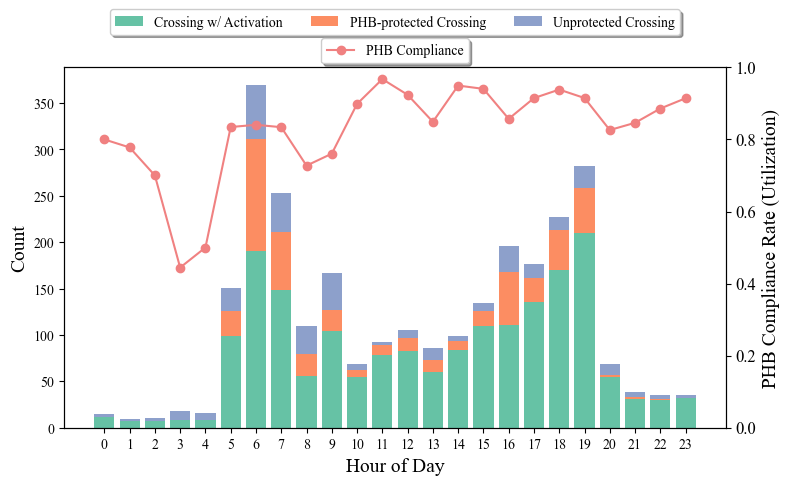

In [17]:
import seaborn as sns
df = total_record_both_way
total_record_both_way['hour'] = total_record_both_way.timestamp.dt.hour
# Aggregate the data: count of each label per hour
counts = df.groupby(['hour', 'PHB_status']).size().unstack(fill_value=0)
counts = counts.sort_index()  # ensure hours are sorted

# Define an attractive color palette from Seaborn (Set2)
palette = sns.color_palette("Set2", 3)
colors = {'Crossing w/ Activation': palette[0], 'PHB-protected Crossing': palette[1], 'Unprotected Crossing': palette[2]}

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Start with a baseline of zeros
bottom = np.zeros(len(counts))

# Plot each label's contribution in the stacked bar
for label in sorted(counts.columns):
    values = counts[label].values
    if label == 'Activation Crossing':
        label = 'Crossing w/ Activation'
    elif label == 'Dependent Crossing':
        label = 'PHB-protected Crossing'
    else:
        label = 'Unprotected Crossing'
    ax.bar(counts.index, values, bottom=bottom, color=colors[label],
           label=f'{label}', width=0.8)
    bottom += values  # update the bottom for stacking
# Add labels and title
ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
# ax.set_title('Stacked Bar Chart of Labels by Hour')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          ncol=3, fancybox=True, shadow=True)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
indepenant_crossing_portion = counts.loc[:,'Independent Crossing']/counts.sum(axis = 1)
# show the portion of indepenant crossing. use right y-axis as the portion
ax2 = ax.twinx()
ax2.plot(1 - indepenant_crossing_portion, color = 'lightcoral', label = 'PHB Compliance', marker = 'o', alpha = 0.99)
ax2.set_ylabel('PHB Compliance Rate (Utilization)', fontsize=14)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\utilization.png')
plt.show()


In [471]:
counts.loc[:,'Independent Crossing'].sum()/counts.sum(axis = 1).sum()

0.13463626492942454

In [473]:
first_arrive_inds = []
following_arrive_inds = []

for i in range(len(total_record_both_way)):
    timestamp = total_record_both_way.timestamp[i]
    mask = (total_record_both_way.timestamp < timestamp) & (total_record_both_way.timestamp > timestamp - timedelta(seconds = 40))
    if (total_record_both_way[mask].event_type == 'Activating').sum() == 0:
        first_arrive_inds.append(i)
    else:
        following_arrive_inds.append(i)
total_record_both_way.loc[:,'Arrival_status'] = 'First Arrival'
total_record_both_way.loc[first_arrive_inds,'Arrival_status'] = 'First Arrival'
total_record_both_way.loc[following_arrive_inds,'Arrival_status'] = 'Following Arrival'

In [477]:
crossing_time

numpy.datetime64('2024-12-08T20:37:00.000000000')

In [479]:
(crossing_time - timestamp)

Timedelta('-1 days +20:50:10')

In [481]:
crossing_time

numpy.datetime64('2024-12-08T20:37:00.000000000')

In [482]:
total_record_both_way

timestamp  event_type location           PHB_status  hour  \
0    2024-12-04 17:00:46  Activating     Left  Activation Crossing    17   
1    2024-12-04 17:01:53  Activating     Left  Activation Crossing    17   
2    2024-12-04 17:02:06    Crossing     Left   Dependent Crossing    17   
3    2024-12-04 17:04:26  Activating     Left  Activation Crossing    17   
4    2024-12-04 17:05:23  Activating     Left  Activation Crossing    17   
...                  ...         ...      ...                  ...   ...   
2758 2024-12-08 23:31:26  Activating     Left  Activation Crossing    23   
2759 2024-12-08 23:31:44  Activating     Left  Activation Crossing    23   
2760 2024-12-08 23:32:32  Activating     Left  Activation Crossing    23   
2761 2024-12-08 23:32:46  Activating     Left  Activation Crossing    23   
2762 2024-12-08 23:46:50  Activating    Right  Activation Crossing    23   

         Arrival_status  
0         First Arrival  
1         First Arrival  
2     Following Arrival  
3         First Arrival  
4         First Arrival  
...                 ...  
2758  Following Arrival  
2759  Following Arrival  
2760      First Arrival  
2761  Following Arrival  
2762      First Arrival  

[2763 rows x 6 columns]

In [528]:
# calculate the time different between dependent crossing and first arrival
waiting_time = []
hours = []
crossing_types = [] # wait crossing / immediate crossing
for i in range(len(total_record_both_way)):
    if (total_record_both_way.Arrival_status[i] == 'First Arrival') & (total_record_both_way.event_type[i] == 'Activating'):
        timestamp = total_record_both_way.timestamp[i]
        mask = (total_record_both_way.timestamp > timestamp) & (total_record_both_way.timestamp < timestamp + timedelta(seconds = 40))
        temp = total_record_both_way[mask]
        if len(temp) == 0:
            crossing_types.append('Immediate Crossing')
            waiting_time.append(0) # immediate crossing
            hours.append(timestamp.hour)
        else:

            for j in range(len(temp)):
                if temp.event_type.iloc[j] == 'Crossing':
                    if (temp.timestamp.iloc[j] - timestamp).seconds < 5:
                        crossing_types.append('Immediate Crossing')
                    else:
                        crossing_types.append('Wait Crossing')
                    waiting_time.append((temp.timestamp.iloc[j] - timestamp).seconds)
                    hours.append(timestamp.hour)
                break
df = pd.DataFrame({'waiting_time':waiting_time,'crossing_tyeps':crossing_types,'hour':hours})

In [547]:
(counts.loc[:,'Wait Crossing'] / (counts.loc[:,'Immediate Crossing'] + counts.loc[:,'Wait Crossing'])).iloc[6:20].mean()

0.25655617775212564

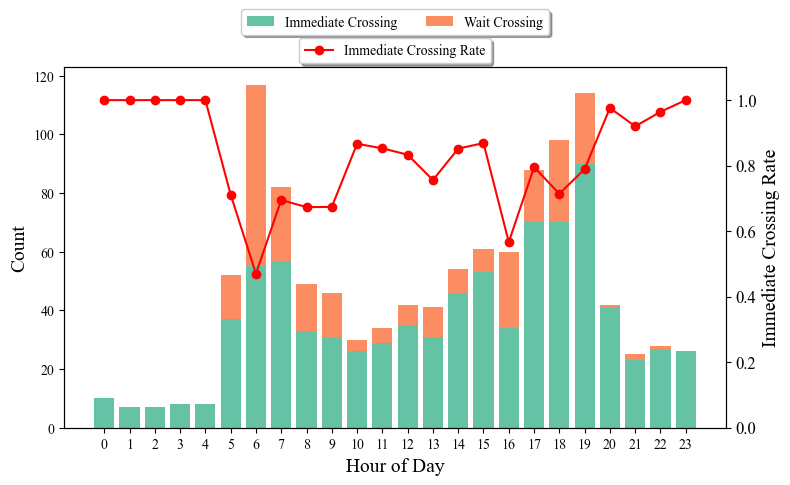

In [544]:
df = df
# Aggregate the data: count of each label per hour
counts = df.groupby(['hour', 'crossing_tyeps']).size().unstack(fill_value=0)
counts = counts.sort_index()  # ensure hours are sorted

# Define an attractive color palette from Seaborn (Set2)
palette = sns.color_palette("Set2", 3)
colors = {'Immediate Crossing': palette[0], 'Wait Crossing': palette[1]}

# Create the stacked bar chart
fig, ax = plt.subplots(figsize=(8, 5))

# Start with a baseline of zeros
bottom = np.zeros(len(counts))

# Plot each label's contribution in the stacked bar
for label in sorted(counts.columns):
    values = counts[label].values
    ax.bar(counts.index, values, bottom=bottom, color=colors[label],
           label=f'{label}', width=0.8)
    bottom += values  # update the bottom for stacking
# Add labels and title
immediate_crossing_portion = counts.loc[:,'Immediate Crossing'] / (counts.loc[:,'Immediate Crossing'] + counts.loc[:,'Wait Crossing'])
# show the portion of indepenant crossing. use right y-axis as the portion
ax2 = ax.twinx()
ax2.plot(immediate_crossing_portion, color = 'red', label = 'Immediate Crossing Rate', marker = 'o', alpha = 0.99)
ax2.set_ylabel('Immediate Crossing Rate', fontsize=14)
ax2.legend(loc='upper center', bbox_to_anchor=(0.5, 1.1),
          ncol=3, fancybox=True, shadow=True)

ax.set_xlabel('Hour of Day', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
# ax.set_title('Stacked Bar Chart of Labels by Hour')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.18),
          ncol=3, fancybox=True, shadow=True)
ax.set_xticks(range(24))
ax.set_xticklabels(range(24))
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0, 1.1)
plt.tight_layout()
plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\waitcrossing.png')
plt.show()


(array([849.,  21.,   9.,  74.,  59.,  33.,  41.,  31.,  32.,  21.]),
 array([ 0. ,  3.9,  7.8, 11.7, 15.6, 19.5, 23.4, 27.3, 31.2, 35.1, 39. ]),
 <BarContainer object of 10 artists>)

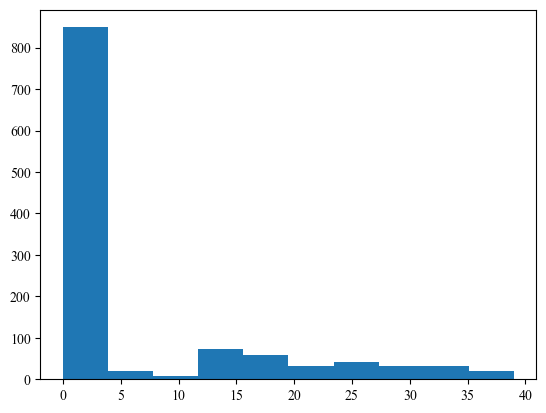

In [521]:
plt.hist(waiting_time)

In [208]:
total_record_both_way.to_csv(os.path.join(r'D:\LiDAR_Data\2ndPHB\Video\EvaluationRes_0202','total_record_both_way.csv'),index = False)

In [211]:
440/(440  + 1445)

0.23342175066312998

In [212]:
total_record_both_way.loc[(total_record_both_way.Arrival_status == 'Following Arrival') & (total_record_both_way.event_type == 'Crossing')]

timestamp event_type location          PHB_status  hour  \
2    2024-12-04 17:02:06   Crossing     Left  Dependent Crossing    17   
5    2024-12-04 17:05:51   Crossing     Left  Dependent Crossing    17   
34   2024-12-04 17:50:51   Crossing     Left  Dependent Crossing    17   
38   2024-12-04 17:56:35   Crossing     Left  Dependent Crossing    17   
59   2024-12-04 18:30:53   Crossing     Left  Dependent Crossing    18   
...                  ...        ...      ...                 ...   ...   
2682 2024-12-08 19:00:34   Crossing    Right  Dependent Crossing    19   
2692 2024-12-08 19:13:49   Crossing     Left  Dependent Crossing    19   
2700 2024-12-08 19:28:41   Crossing     Left  Dependent Crossing    19   
2716 2024-12-08 19:41:42   Crossing     Left  Dependent Crossing    19   
2743 2024-12-08 21:01:21   Crossing     Left  Dependent Crossing    21   

         Arrival_status  
2     Following Arrival  
5     Following Arrival  
34    Following Arrival  
38    Following Arrival  
59    Following Arrival  
...                 ...  
2682  Following Arrival  
2692  Following Arrival  
2700  Following Arrival  
2716  Following Arrival  
2743  Following Arrival  

[425 rows x 6 columns]

In [209]:
total_record_both_way.loc[(total_record_both_way.Arrival_status == 'Following Arrival') & (total_record_both_way.event_type == 'Activating')]

timestamp  event_type location           PHB_status  hour  \
8    2024-12-04 17:08:17  Activating     Left  Activation Crossing    17   
10   2024-12-04 17:09:58  Activating     Left  Activation Crossing    17   
11   2024-12-04 17:10:04  Activating     Left  Activation Crossing    17   
13   2024-12-04 17:13:03  Activating     Left  Activation Crossing    17   
15   2024-12-04 17:15:38  Activating     Left  Activation Crossing    17   
...                  ...         ...      ...                  ...   ...   
2749 2024-12-08 22:20:28  Activating    Right  Activation Crossing    22   
2757 2024-12-08 23:31:08  Activating     Left  Activation Crossing    23   
2758 2024-12-08 23:31:26  Activating     Left  Activation Crossing    23   
2759 2024-12-08 23:31:44  Activating     Left  Activation Crossing    23   
2761 2024-12-08 23:32:46  Activating     Left  Activation Crossing    23   

         Arrival_status  
8     Following Arrival  
10    Following Arrival  
11    Following Arrival  
13    Following Arrival  
15    Following Arrival  
...                 ...  
2749  Following Arrival  
2757  Following Arrival  
2758  Following Arrival  
2759  Following Arrival  
2761  Following Arrival  

[440 rows x 6 columns]

In [213]:
total_record_both_way.loc[(total_record_both_way.Arrival_status == 'First Arrival') & (total_record_both_way.event_type == 'Crossing')] 

timestamp event_type location            PHB_status  hour  \
41   2024-12-04 18:00:50   Crossing     Left  Independent Crossing    18   
90   2024-12-04 18:57:29   Crossing     Left  Independent Crossing    18   
95   2024-12-04 19:01:05   Crossing     Left  Independent Crossing    19   
125  2024-12-04 19:25:22   Crossing     Left  Independent Crossing    19   
129  2024-12-04 19:30:05   Crossing    Right  Independent Crossing    19   
...                  ...        ...      ...                   ...   ...   
2731 2024-12-08 20:14:32   Crossing     Left  Independent Crossing    20   
2732 2024-12-08 20:15:09   Crossing    Right  Independent Crossing    20   
2734 2024-12-08 20:28:47   Crossing     Left  Independent Crossing    20   
2737 2024-12-08 20:36:11   Crossing     Left  Independent Crossing    20   
2738 2024-12-08 20:37:00   Crossing     Left  Independent Crossing    20   

     Arrival_status  
41    First Arrival  
90    First Arrival  
95    First Arrival  
125   First Arrival  
129   First Arrival  
...             ...  
2731  First Arrival  
2732  First Arrival  
2734  First Arrival  
2737  First Arrival  
2738  First Arrival  

[453 rows x 6 columns]

In [210]:
total_record_both_way.loc[(total_record_both_way.Arrival_status == 'First Arrival') & (total_record_both_way.event_type == 'Activating')] 

timestamp  event_type location           PHB_status  hour  \
0    2024-12-04 17:00:46  Activating     Left  Activation Crossing    17   
1    2024-12-04 17:01:53  Activating     Left  Activation Crossing    17   
3    2024-12-04 17:04:26  Activating     Left  Activation Crossing    17   
4    2024-12-04 17:05:23  Activating     Left  Activation Crossing    17   
6    2024-12-04 17:06:22  Activating     Left  Activation Crossing    17   
...                  ...         ...      ...                  ...   ...   
2754 2024-12-08 23:26:21  Activating     Left  Activation Crossing    23   
2755 2024-12-08 23:29:55  Activating     Left  Activation Crossing    23   
2756 2024-12-08 23:30:54  Activating     Left  Activation Crossing    23   
2760 2024-12-08 23:32:32  Activating     Left  Activation Crossing    23   
2762 2024-12-08 23:46:50  Activating    Right  Activation Crossing    23   

     Arrival_status  
0     First Arrival  
1     First Arrival  
3     First Arrival  
4     First Arrival  
6     First Arrival  
...             ...  
2754  First Arrival  
2755  First Arrival  
2756  First Arrival  
2760  First Arrival  
2762  First Arrival  

[1445 rows x 6 columns]

In [472]:
total_record_both_way

timestamp  event_type location           PHB_status  hour
0    2024-12-04 17:00:46  Activating     Left  Activation Crossing    17
1    2024-12-04 17:01:53  Activating     Left  Activation Crossing    17
2    2024-12-04 17:02:06    Crossing     Left   Dependent Crossing    17
3    2024-12-04 17:04:26  Activating     Left  Activation Crossing    17
4    2024-12-04 17:05:23  Activating     Left  Activation Crossing    17
...                  ...         ...      ...                  ...   ...
2758 2024-12-08 23:31:26  Activating     Left  Activation Crossing    23
2759 2024-12-08 23:31:44  Activating     Left  Activation Crossing    23
2760 2024-12-08 23:32:32  Activating     Left  Activation Crossing    23
2761 2024-12-08 23:32:46  Activating     Left  Activation Crossing    23
2762 2024-12-08 23:46:50  Activating    Right  Activation Crossing    23

[2763 rows x 5 columns]

In [39]:
evluation_table = pd.read_excel(r'D:\LiDAR_Data\2ndPHB\Video\HAWK Pedestrian Behavior Compiled Data.xlsx')
evluation_table = evluation_table.iloc[150:766]
evluation_table = evluation_table.reset_index(drop=True)
evluation_table_left = evluation_table[evluation_table['Bound'] == 'N'].copy()
evluation_table_right = evluation_table[evluation_table['Bound'] == 'S'].copy()
timestamp = evluation_table_left['Date'].astype(str) + '_' + evluation_table_left['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
# convert to datetime
timestamp = pd.to_datetime(timestamp, format='%Y%m%d_%H%M%S')
evluation_table_left['timestamp'] = timestamp

timestamp = evluation_table_right['Date'].astype(str) + '_' + evluation_table_right['Time'].astype(str)
timestamp = timestamp.str.replace(':','')
timestamp = timestamp.str.replace('-','')
# convert to datetime
timestamp = pd.to_datetime(timestamp, format='%Y%m%d_%H%M%S')
evluation_table_right['timestamp'] = timestamp


In [40]:
total_summary_left_eva = total_summary_left.loc[(total_summary_left.timestamp < datetime(2024,12,6,0,0,0) ) & (total_summary_left.timestamp > datetime(2024,12,5,0,0,0))].copy()
total_summary_right_eva = total_summary_right.loc[(total_summary_right.timestamp < datetime(2024,12,6,0,0,0) ) & (total_summary_right.timestamp > datetime(2024,12,5,0,0,0))].copy()


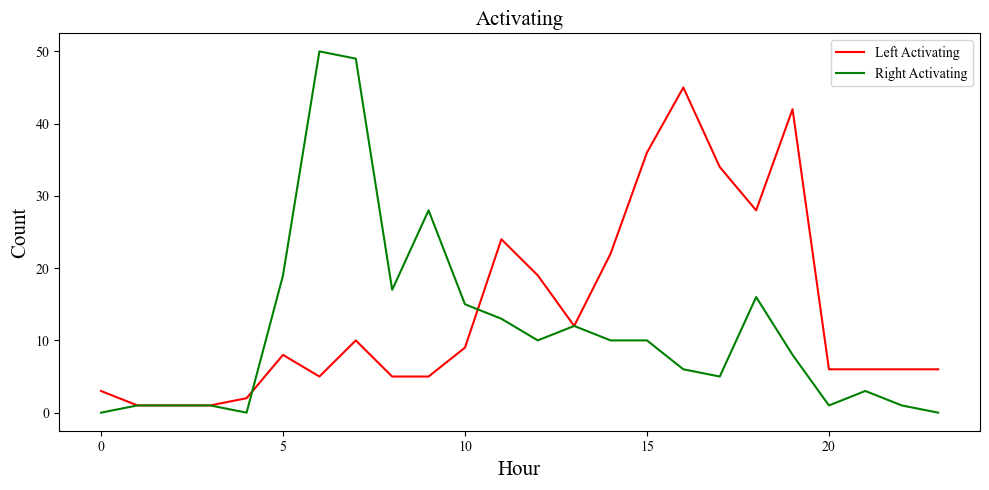

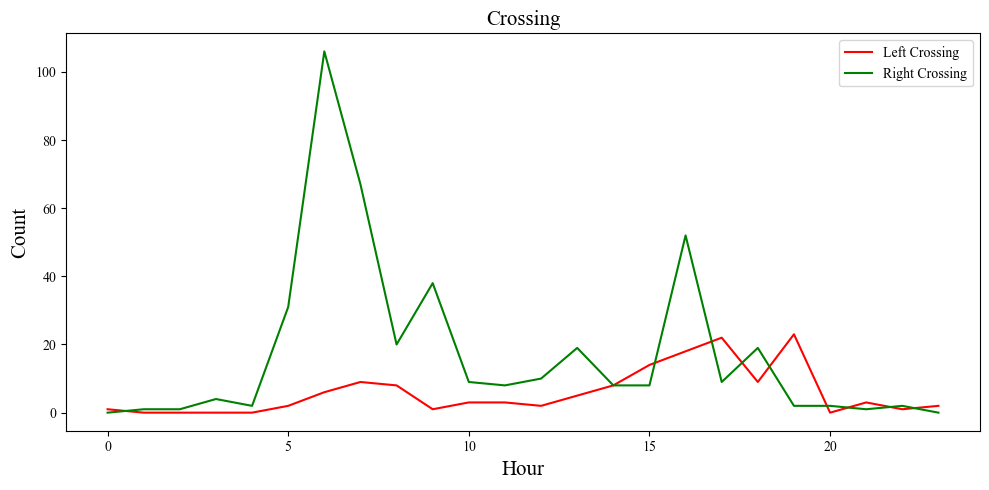

In [41]:
activating_left_count = np.zeros(24)
crossing_left_count = np.zeros(24)
activating_right_count = np.zeros(24)
crossing_right_count = np.zeros(24)
for i in range(24):
    activating_left_count[i] = (total_summary_left_eva.event_type == 'Activating').loc[total_summary_left_eva.timestamp.dt.hour == i].sum()
    crossing_left_count[i] = (total_summary_left_eva.event_type == 'Crossing').loc[total_summary_left_eva.timestamp.dt.hour == i].sum()
    activating_right_count[i] = (total_summary_right_eva.event_type == 'Activating').loc[total_summary_right_eva.timestamp.dt.hour == i].sum()
    crossing_right_count[i] = (total_summary_right_eva.event_type == 'Crossing').loc[total_summary_right_eva.timestamp.dt.hour == i].sum()
# plot the activating and crossing count
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), activating_left_count, label='Left Activating', color='r')
ax.plot(range(24), activating_right_count, label='Right Activating', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Activating', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), crossing_left_count, label='Left Crossing', color='r')
ax.plot(range(24), crossing_right_count, label='Right Crossing', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Crossing', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()


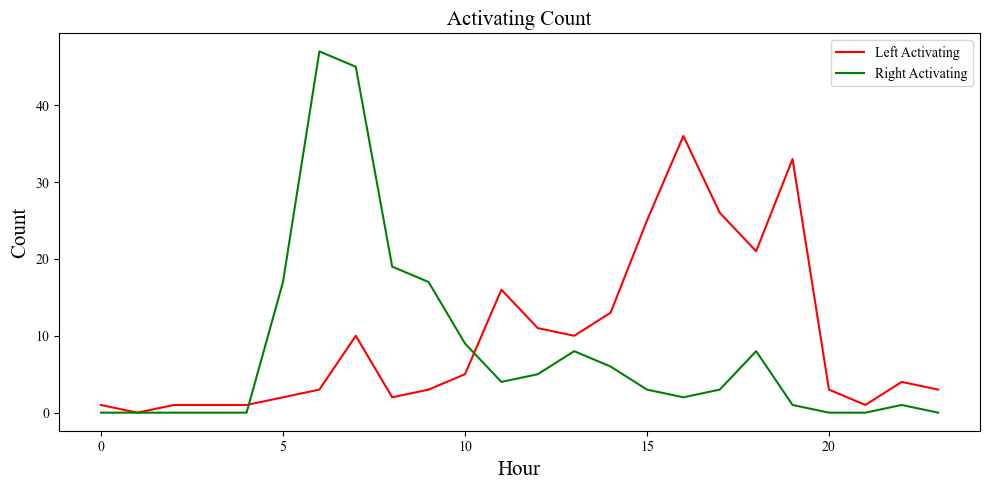

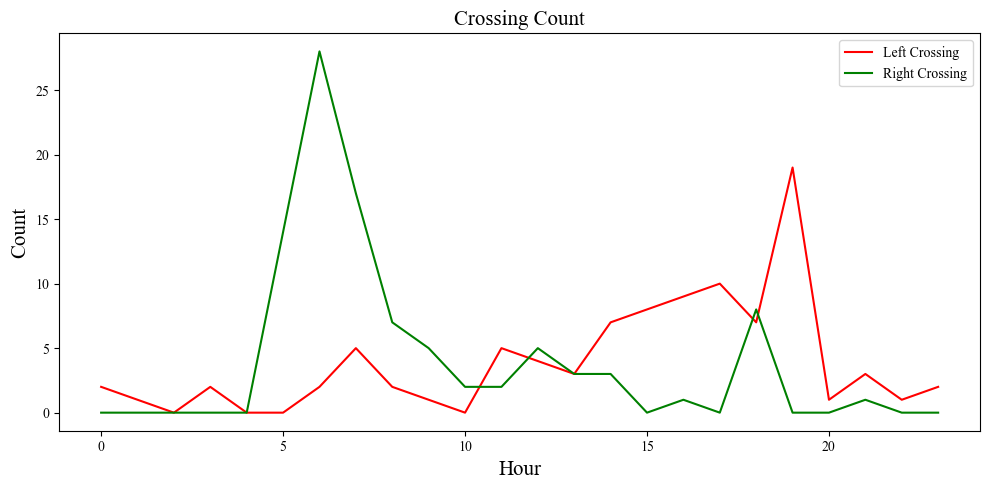

In [42]:
activating_left_count = np.zeros(24)
crossing_left_count = np.zeros(24)
activating_right_count = np.zeros(24)
crossing_right_count = np.zeros(24)
for i in range(24):
    activating_left_count[i] = (evluation_table_left['Pressed?'] == 'Y').loc[evluation_table_left.timestamp.dt.hour == i].sum()
    crossing_left_count[i] = (evluation_table_left['Pressed?'] == 'N').loc[evluation_table_left.timestamp.dt.hour == i].sum()
    activating_right_count[i] = (evluation_table_right['Pressed?'] == 'Y').loc[evluation_table_right.timestamp.dt.hour == i].sum()
    crossing_right_count[i] = (evluation_table_right['Pressed?'] == 'N').loc[evluation_table_right.timestamp.dt.hour == i].sum()
# plot the activating and crossing count
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), activating_left_count, label='Left Activating', color='r')
ax.plot(range(24), activating_right_count, label='Right Activating', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Activating Count', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(range(24), crossing_left_count, label='Left Crossing', color='r')
ax.plot(range(24), crossing_right_count, label='Right Crossing', color='g')
ax.set_xlabel('Hour', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Crossing Count', fontsize=15)
ax.legend()
plt.tight_layout()
# plt.savefig(r'D:\Onedrive\OneDrive - University of Nevada, Reno\Academia\PHB\Figs\activating_crossing_count.png',dpi = 300)
plt.show()


In [275]:
evluation_table_left

Event ID  # of Pedestrians Pressed?       Date      Time Bound  \
0         1.0               1.0        Y 2024-12-04  17:00:47     N   
1         2.0               1.0        Y 2024-12-04  17:01:57     N   
2         3.0               1.0        N 2024-12-04  17:02:03     N   
3         4.0               1.0        Y 2024-12-04  17:04:29     N   
4         5.0               1.0        Y 2024-12-04  17:05:23     N   
..        ...               ...      ...        ...       ...   ...   
134     135.0               1.0        Y 2024-12-04  22:25:53     N   
135     136.0               1.0        N 2024-12-04  22:29:06     N   
136     137.0               1.0        Y 2024-12-04  22:31:13     N   
137     138.0               1.0        N 2024-12-04  22:38:43     N   
138     139.0               2.0        Y 2024-12-04  22:42:29     N   

              timestamp  
0   2024-12-04 17:00:47  
1   2024-12-04 17:01:57  
2   2024-12-04 17:02:03  
3   2024-12-04 17:04:29  
4   2024-12-04 17:05:23  
..                  ...  
134 2024-12-04 22:25:53  
135 2024-12-04 22:29:06  
136 2024-12-04 22:31:13  
137 2024-12-04 22:38:43  
138 2024-12-04 22:42:29  

[121 rows x 7 columns]